# MadMiner particle physics tutorial

# Part 4a: Limit setting

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 4a of this tutorial we will use the networks trained in step 3a and 3b to calculate the expected limits on our theory parameters.

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.limits import AsymptoticLimits
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.plotting import plot_histograms


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        # print("Deactivating logging output for", key)
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Preparations

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [3]:
limits = AsymptoticLimits('data/delphes_data_shuffled.h5')

20:20 madminer.analysis    INFO    Loading data from data/delphes_data_shuffled.h5
20:20 madminer.analysis    INFO    Found 1 parameters
20:20 madminer.analysis    INFO    Did not find nuisance parameters
20:20 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:20 madminer.analysis    INFO    Found 35 observables
20:20 madminer.analysis    INFO    Found 2456775 events
20:20 madminer.analysis    INFO      638139 signal events sampled from benchmark no-higgs
20:20 madminer.analysis    INFO      612261 signal events sampled from benchmark 0.8_k
20:20 madminer.analysis    INFO      604045 signal events sampled from benchmark sm
20:20 madminer.analysis    INFO      602330 signal events sampled from benchmark 1.5_k
20:20 madminer.analysis    INFO    Found morphing setup with 5 components
20:20 madminer.analysis    INFO    Did not find nuisance morphing setup


This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

First we have to define the parameter grid on which we evaluate the p-values.

In [4]:
grid_ranges = [(0., 2.)]
grid_resolutions = [51]

What luminosity (in inverse pb) are we talking about?

In [5]:
lumi = 1.#1.

In [6]:
p_values = {}
mle = {}

## 2. Expected limits based on histogram

First, as a baseline, let us calculate the expected limits based on a simple jet pT histogram. Right now, there are not a lot of option for this function; MadMiner even calculates the binning automatically. (We will add more functionality!)

The keyword `include_xsec` determines whether we include information from the total rate or just use the shapes. Since we don't model backgrounds and systematics in this tutorial, the rate information is unrealistically large, so we leave it out here.

In [7]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    #hist_vars=["pt_j1", "delta_eta_jj"],
    #hist_bins=[[0.,40.,60.,80.,100.,150.,200.,300.,400.,1000.]],
    #hist_bins=[[0.,40.,80.,100.,150.,200.,300.,400.,1000.]],
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["Histogram"] = p_values_expected_histo
mle["Histogram"] = best_fit_expected_histo

20:20 madminer.limits      INFO    Generating Asimov data
20:20 madminer.limits      INFO    Expected events: 0.27662085993089414
20:20 madminer.limits      INFO    Setting up standard summary statistics
20:20 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
20:20 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
20:20 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:20 madminer.limits      INFO    Calculating p-values


With `mode="rate"`, we could calculate limits based on only the rate -- but again, since the rate is extremely powerful when backgrounds and systematics are not taken into account, we don't do that in this tutorial.

Let's visualize the likelihood estimated with these histograms:

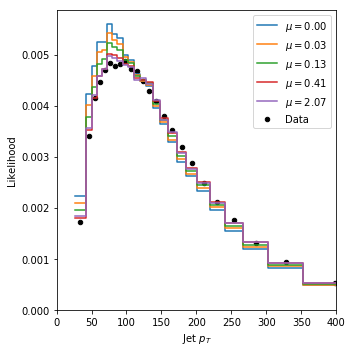

In [8]:
#indices = [12 + i * 25 for i in [6,9,12,15,18]]
#indices = [0,5,6,10,15,20]
#indices = [0,3,16,31,50]
#indices = [0,1,2,5,10]
indices = [0,22,25,32,37,50]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    observed=[observed[i] for i in indices],
    observed_weights=observed_weights,
    histo_labels=[r"$\mu = {:.2f}$".format(theta_grid[i,0]**4) for i in indices],
    xlabel="Jet $p_T$",
    xrange=(0.,400.),
    #xrange=(0.,5.),
)

plt.show()


## 3. Expected limits based on ratio estimators

Next, `mode="ml"` allows us to calculate limits based on any `ParamterizedRatioEstimator` instance like the ALICES estimator trained above:

In [22]:
theta_grid, p_values_expected_alices, best_fit_expected_alices, _, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES"] = p_values_expected_alices
mle["ALICES"] = best_fit_expected_alices

20:34 madminer.limits      INFO    Generating Asimov data
20:34 madminer.limits      INFO    Expected events: 0.27662085993089414
20:34 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
20:34 madminer.ml          INFO    Loading model from models/alices
20:34 madminer.ml          WARNING Parameter scaling information not found in models/alices
20:34 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
20:34 madminer.ml          INFO    Loading evaluation data
20:34 madminer.ml          INFO    Starting ratio evaluation for 6157230 x-theta combinations
20:36 madminer.ml          INFO    Evaluation done
20:36 madminer.limits      INFO    Calculating p-values


## 4. Expected limits based on score estimators

To get p-values from a SALLY estimator, we have to use histograms of the estimated score:

In [16]:
theta_grid, p_values_expected_sally, best_fit_expected_sally, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="sally",
    model_file='models/sally',
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    #hist_bins=[[0.,5.,10.,15., 20.,25., 30.,35., 40., 45., 50.,55., 80., 100.]],
    #hist_bins=[[0.,10., 20., 30., 40., 50., 80., 100.]],
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["SALLY"] = p_values_expected_sally
mle["SALLY"] = best_fit_expected_sally

20:30 madminer.limits      INFO    Generating Asimov data
20:30 madminer.limits      INFO    Expected events: 0.27662085993089414
20:30 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
20:30 madminer.ml          INFO    Loading model from models/sally
20:30 madminer.ml          INFO    Starting score evaluation
20:30 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
20:30 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
20:30 madminer.ml          INFO    Starting score evaluation
20:30 madminer.ml          INFO    Starting score evaluation
20:30 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:30 madminer.limits      INFO    Calculating p-values


Let's have a look at the underlying 2D histograms:

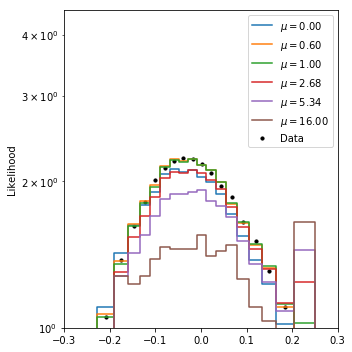

In [21]:
#indices = [12 + i * 25 for i in [0,6,12,18,24]]
#indices = [0,15,25,35,40,50]
#indices = [0,3,16,31,50]
#indices = [0,1,2,3,5,10]
#indices = [0,10,15,20,30]
indices = [0,22,25,32,37,50]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    #observed=observed[0,:100,:],
    #observed_weights=observed_weights[:100],
    observed=observed[0,:,:],
    observed_weights=observed_weights,
    histo_labels=[r"$\mu = {:.2f}$".format(theta_grid[i,0]**4) for i in indices],
    #xlabel=r'$\hat{t}_0(x)$',
    #ylabel=r'$\hat{t}_1(x)$',
    xrange=(-0.3,0.3),
    yrange=(1.,4.5),
    log=True,
    #zrange=(1.e-3,1.),
    markersize=10.
)
    

In [13]:
theta_grid, p_values_expected_sally, best_fit_expected_sally, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="adaptive-sally",
    model_file='models/sally',
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["SALLY-adaptive"] = p_values_expected_sally
mle["SALLY-adaptive"] = best_fit_expected_sally


20:29 madminer.limits      INFO    Generating Asimov data
20:29 madminer.limits      INFO    Expected events: 0.27662085993089414
20:29 madminer.limits      WARNING The SALLINO and adaptive SALLY methods require the reference point, but the argument thetaref was not provided. Assuming thetaref = [0.].
20:29 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
20:29 madminer.ml          INFO    Loading model from models/sally
20:29 madminer.ml          INFO    Starting score evaluation
20:29 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
20:29 madminer.ml          INFO    Starting score evaluation
20:29 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:29 madminer.limits      INFO    Calculating p-values


In [14]:
theta_grid, p_values_expected_sallino, best_fit_expected_sallino, _, _, histos = limits.expected_limits(
    mode="sallino",
    model_file='models/sally',
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    test_split=0.5
)

p_values["SALLINO"] = p_values_expected_sallino
mle["SALLINO"] = best_fit_expected_sallino

20:29 madminer.limits      INFO    Generating Asimov data
20:29 madminer.limits      INFO    Expected events: 0.27662085993089414
20:29 madminer.limits      WARNING The SALLINO and adaptive SALLY methods require the reference point, but the argument thetaref was not provided. Assuming thetaref = [0.].
20:29 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
20:29 madminer.ml          INFO    Loading model from models/sally
20:29 madminer.ml          INFO    Starting score evaluation
20:29 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
20:29 madminer.ml          INFO    Starting score evaluation
20:29 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:29 madminer.limits      INFO    Calculating p-values


In [30]:
theta_grid, p_values_expected_scandal, best_fit_expected_scandal, _, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/scandal',
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    test_split=0.5
)

p_values["SCANDAL"] = p_values_expected_scandal
mle["SCANDAL"] = best_fit_expected_scandal

21:11 madminer.limits      INFO    Generating Asimov data
21:11 madminer.limits      INFO    Expected events: 0.27662085993089414
21:11 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
21:11 madminer.ml          INFO    Loading model from models/scandal
21:11 madminer.ml          WARNING Parameter scaling information not found in models/scandal
21:11 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
21:11 madminer.ml          INFO    Starting ratio evaluation for 15398328 x-theta combinations
21:17 madminer.ml          INFO    Evaluation done
21:17 madminer.limits      INFO    Calculating p-values


## 6. Toy signal

In addition to these expected limits (based on the SM), let us inject a mock signal. We first generate the data:

In [24]:
theta_grid, p_values_expected_alices, best_fit_expected_alices, _, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[1.5],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    test_split=0.5
)

p_values["ALICES signal"] = p_values_expected_alices
mle["ALICES signal"] = best_fit_expected_alices

20:36 madminer.limits      INFO    Generating Asimov data
20:36 madminer.limits      INFO    Expected events: 0.3443641708920965
20:36 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
20:36 madminer.ml          INFO    Loading model from models/alices
20:36 madminer.ml          WARNING Parameter scaling information not found in models/alices
20:36 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
20:36 madminer.ml          INFO    Loading evaluation data
20:36 madminer.ml          INFO    Starting ratio evaluation for 15331620 x-theta combinations
20:42 madminer.ml          INFO    Evaluation done
20:42 madminer.limits      INFO    Calculating p-values


In [25]:
theta_grid, p_values_expected_sally, best_fit_expected_sally, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="sally",
    model_file='models/sally',
    theta_true=[1.5],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["SALLY signal"] = p_values_expected_sally
mle["SALLY signal"] = best_fit_expected_sally

20:42 madminer.limits      INFO    Generating Asimov data
20:42 madminer.limits      INFO    Expected events: 0.3443641708920965
20:42 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
20:42 madminer.ml          INFO    Loading model from models/sally
20:42 madminer.ml          INFO    Starting score evaluation
20:42 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
20:42 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
20:42 madminer.ml          INFO    Starting score evaluation
20:42 madminer.ml          INFO    Starting score evaluation
20:42 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:42 madminer.limits      INFO    Calculating p-values


In [31]:
theta_grid, p_values_expected_scandal, best_fit_expected_scandal, _, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/scandal',
    theta_true=[1.5],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    test_split=0.5
)

p_values["SCANDAL signal"] = p_values_expected_scandal
mle["SCANDAL signal"] = best_fit_expected_scandal

21:17 madminer.limits      INFO    Generating Asimov data
21:17 madminer.limits      INFO    Expected events: 0.3443641708920965
21:17 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
21:17 madminer.ml          INFO    Loading model from models/scandal
21:17 madminer.ml          WARNING Parameter scaling information not found in models/scandal
21:17 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
21:17 madminer.ml          INFO    Starting ratio evaluation for 15331620 x-theta combinations
21:23 madminer.ml          INFO    Evaluation done
21:23 madminer.limits      INFO    Calculating p-values


In [26]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    theta_true=[1.5],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["Histogram signal"] = p_values_expected_histo
mle["Histogram signal"] = best_fit_expected_histo

20:42 madminer.limits      INFO    Generating Asimov data
20:42 madminer.limits      INFO    Expected events: 0.3443641708920965
20:42 madminer.limits      INFO    Setting up standard summary statistics
20:42 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
20:42 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
20:42 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:42 madminer.limits      INFO    Calculating p-values


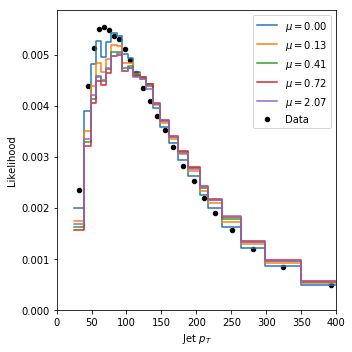

In [27]:
#indices = [12 + i * 25 for i in [6,9,12,15,18]]
#indices = [0,5,6,10,15,20]
#indices = [0,3,16,31,50]
#indices = [0,1,2,5,10]
indices = [0,22,25,32,37,50]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    observed=[observed[i] for i in indices],
    observed_weights=observed_weights,
    histo_labels=[r"$\mu = {:.2f}$".format(theta_grid[i,0]**4) for i in indices],
    xlabel="Jet $p_T$",
    xrange=(0.,400.),
    #xrange=(0.,5.),
)

plt.show()



In [28]:
theta_grid, p_values_expected_sally, best_fit_expected_sally, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="adaptive-sally",
    model_file='models/sally',
    theta_true=[1.5],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5,
    thetaref=[0.]
)

p_values["SALLY-adaptive signal"] = p_values_expected_sally
mle["SALLY-adaptive signal"] = best_fit_expected_sally



20:42 madminer.limits      INFO    Generating Asimov data
20:42 madminer.limits      INFO    Expected events: 0.3443641708920965
20:42 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
20:42 madminer.ml          INFO    Loading model from models/sally
20:42 madminer.ml          INFO    Starting score evaluation
20:42 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
20:42 madminer.ml          INFO    Starting score evaluation
20:42 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:42 madminer.limits      INFO    Calculating p-values


## Plot

Let's plot the results:

[0.84934656] SALLY
[0.07311616] ALICES
[1.36048896] Histogram
[1.16985856] SALLINO
[2.0736] SCANDAL
[1.] SALLY-adaptive


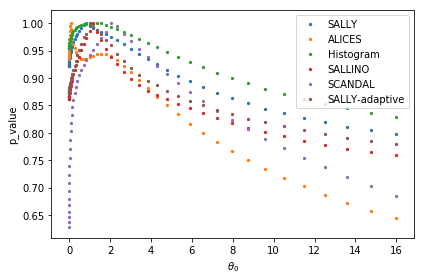

In [32]:
#show = "ALICES"
cmin, cmax = 1.e-3, 1.

bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    if (label.find("signal") != -1):
        continue
    #plt.scatter(centers**2, p_value, label=label)
    plt.scatter(centers**4, p_value, label=label, s=5)
    print (theta_grid[mle[label]]**4, label)
#     plt.scatter(
#         theta_grid[mle[label]], theta_grid[mle[label]][1],
#         s=80., color='C{}'.format(i), marker='*',
#         label=label
#     )

plt.legend()

plt.xlabel(r'$\theta_0$')
#plt.xlabel(r'$\mu$')
plt.ylabel(r'p_value')
#plt.xlim(0,6)
#plt.ylim(0.4,1.03)

plt.tight_layout()
plt.show()



In [ ]:
theta_grid**4

[1.52] [5.33794816] SALLY signal
[1.52] [5.33794816] Histogram signal
[1.52] [5.33794816] SCANDAL signal
[1.04] [1.16985856] SALLY-adaptive signal
[1.52] [5.33794816] ALICES signal


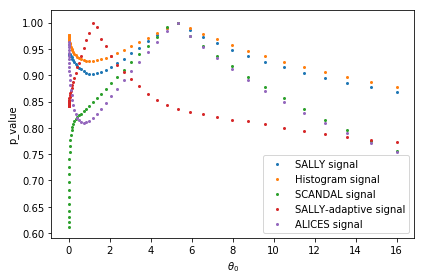

In [33]:
bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    if (label.find("signal") == -1):
        continue
    plt.scatter(centers**4, p_value, label=label, s=4)
    print (theta_grid[mle[label]],theta_grid[mle[label]]**4, label)
#     plt.scatter(
#         theta_grid[mle[label]][0], theta_grid[mle[label]][1],
#         s=80., color='C{}'.format(i), marker='*',
#         label=label
#     )

plt.legend()

plt.xlabel(r'$\theta_0$')
#plt.xlabel(r'$\mu$')
plt.ylabel(r'p_value')

plt.tight_layout()
plt.show()




In [ ]:
theta_grid **4

In [ ]:
#show = "ALICES"
cmin, cmax = 1.e-3, 1.

bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    if (label.find("signal") != -1) or (label.find("SCANDAL") != -1):
        continue
    #plt.scatter(centers**2, p_value, label=label)
    plt.scatter(centers, p_value, label=label, s=5)
    print (theta_grid[mle[label]],theta_grid[mle[label]]**4, label)
#     plt.scatter(
#         theta_grid[mle[label]], theta_grid[mle[label]][1],
#         s=80., color='C{}'.format(i), marker='*',
#         label=label
#     )
#plt.hlines(y=0.95, xmin=0, xmax=2, colors='grey')
plt.legend()

#plt.xlabel(r'$\theta_0$')
plt.xlabel(r'$\mu^{\frac{1}{4}}$')
plt.ylabel(r'p_value')
#plt.xlim(0,6)
#plt.ylim(0.4,1.03)

plt.tight_layout()
plt.show()


